In [ ]:
# NOTE: Install with pip install sixdrepnet
from sixdrepnet import SixDRepNet
import cv2
import os 
from tqdm import tqdm 
import json 
import numpy as np 
import re 




main_folder ="../../FR_DATASETS_ABLATION"
main_output_folder = "HEAD_POSE_ESTIMATIONS_ID-Booth_FR"

synth_folders = [   #"12-2024_SD21_LoRA4_alphaWNone_FINAL_FacePortraitPhoto_Gender_Pose_BackgroundB",
                # "12-2024_SD21_LoRA4_alphaWNone_FacePortrait_Photo_Gender_Pose_BackgroundB_100samples"
                "01-2025_ID-Booth_ABLATION"
                ]

real_folders = ["tufts_512_poses_1-7_all_imgs_jpg_per_ID/tufts_images"] #]#["tufts_512_poses_1-7_all_imgs_jpg_per_ID/tufts_images", "FFHQ_512/images"]

# loss_exps = ["no_new_Loss_NonFinetuned", "no_new_Loss", "identity_loss_TimestepWeight", "triplet_prior_loss_TimestepWeight"]
loss_exps = ["no_new_Loss_NoPrior"]


all_folders = []
for fold in synth_folders: 
    for loss_exp in loss_exps: 
        all_folders.append(os.path.join(fold, loss_exp))

for fold in real_folders:
    all_folders.append(fold)


##############################################
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

##############################################

model = SixDRepNet()

for fold in all_folders: 
    #for loss_exp in loss_exps:
        
    img_folder_path = f"{main_folder}/{fold}"#/{loss_exp}" 
    print(img_folder_path)

    output_folder = f"{main_output_folder}/{img_folder_path.split('/')[-2]}"
    os.makedirs(output_folder, exist_ok=True)
    output_file = f"{output_folder}/{img_folder_path.split('/')[-1]}.json"

    if os.path.exists(output_file): 
        print("Results already generated")
        continue 

    yaw_dist = []; pitch_dist = []; roll_dist = []
    yaw_per_id, pitch_per_id, roll_per_id = dict(),  dict(),  dict()
    
    imgs = os.listdir(img_folder_path)        
    imgs.sort(key=natural_keys)

    upscale = 30

    for img_name in tqdm(imgs): 
        #if "2_10" not in img_name:continue 
        img = cv2.imread(os.path.join(img_folder_path, img_name))
        # TODO add padding to better determine the pose of large obstructed faces
        img = cv2.copyMakeBorder(img, upscale, upscale, upscale, upscale, cv2.BORDER_CONSTANT)
        pitch, yaw, roll = model.predict(img)
        # print(pitch, yaw, roll)

        pitch, yaw, roll = float(pitch), float(yaw), float(roll)

        yaw_dist.append(yaw)
        pitch_dist.append(pitch)
        roll_dist.append(roll)

        tmp_id = img_name.split("_")[0]
        if tmp_id not in yaw_per_id: 
            yaw_per_id[tmp_id] = [yaw]
            pitch_per_id[tmp_id] = [pitch]
            roll_per_id[tmp_id] = [roll]
            
        else: 
            yaw_per_id[tmp_id].append(yaw)
            pitch_per_id[tmp_id].append(pitch)
            roll_per_id[tmp_id].append(roll)
    #break 
    # continue 
    print(round(np.mean(yaw_dist), 3), round(np.std(yaw_dist),3) )

    result = {
                "yaw": yaw_dist,
                "yaw_per_id": yaw_per_id, 
                "pitch": pitch_dist,
                "pitch_per_id": pitch_per_id, 
                "roll": roll_dist,
                "roll_per_id": roll_per_id, 
        }

    with open(output_file, "w") as f: 
        json.dump(result, f)

    print("===" * 30)





../../FR_DATASETS_ABLATION/01-2025_ID-Booth_ABLATION/+Background_NoNegPrompt


100%|██████████| 10636/10636 [01:06<00:00, 158.79it/s]


1.767 16.471
../../FR_DATASETS_ABLATION/01-2025_ID-Booth_ABLATION/Base_NoNegPrompt


100%|██████████| 10696/10696 [01:07<00:00, 158.19it/s]


1.959 8.452
../../FR_DATASETS_ABLATION/tufts_512_poses_1-7_all_imgs_jpg_per_ID/tufts_images
Results already generated


In [8]:
new_order = []

for fold in all_folders: 
    #for loss_exp in loss_exps:
    #if "tufts" in fold or "FFHQ" in fold: loss_exp = "images"
    path = os.path.join(f"{fold}.json")#, f"{loss_exp}.json")
    new_order.append(path)

new_order

['01-2025_ID-Booth_ABLATION/+Background_NoNegPrompt.json',
 '01-2025_ID-Booth_ABLATION/Base_NoNegPrompt.json',
 'tufts_512_poses_1-7_all_imgs_jpg_per_ID/tufts_images.json']

In [9]:

name_translator_dict = dict()

for fold in all_folders: 
    #for loss_exp in loss_exps:
    # add = ""
    if "tufts" in fold or "FFHQ" in fold: 
        new_name = f"{fold.split('_')[0]}      " #{add}"

    else:
        # #if "base" in fold: add = "Base"
        # if "Face_Poses_Environments" in fold: add = "Complex"
        # else: add = "Base"

        loss_add = ""
        if "no_new" in fold: loss_add = "     "
        if "identity" in fold: loss_add = "+  ID"
        if "triplet_prior" in fold: loss_add = "+ TID"

        new_name = f"SD-2.1 {loss_add}"
    name_translator_dict[f"{fold}.json"] = new_name 

name_translator_dict

{'01-2025_ID-Booth_ABLATION/+Background_NoNegPrompt.json': 'SD-2.1 ',
 '01-2025_ID-Booth_ABLATION/Base_NoNegPrompt.json': 'SD-2.1 ',
 'tufts_512_poses_1-7_all_imgs_jpg_per_ID/tufts_images.json': 'tufts      '}

SD-2.1  & $-2.215 \pm 6.856$ &               $1.767 \pm 16.471$ &                 $-0.106 \pm 2.726$ \\
SD-2.1  & $0.282 \pm 6.506$ &               $1.959 \pm 8.452$ &                 $0.074 \pm 1.465$ \\
tufts       & $0.354 \pm 5.83$ &               $0.183 \pm 27.483$ &                 $-0.343 \pm 2.644$ \\


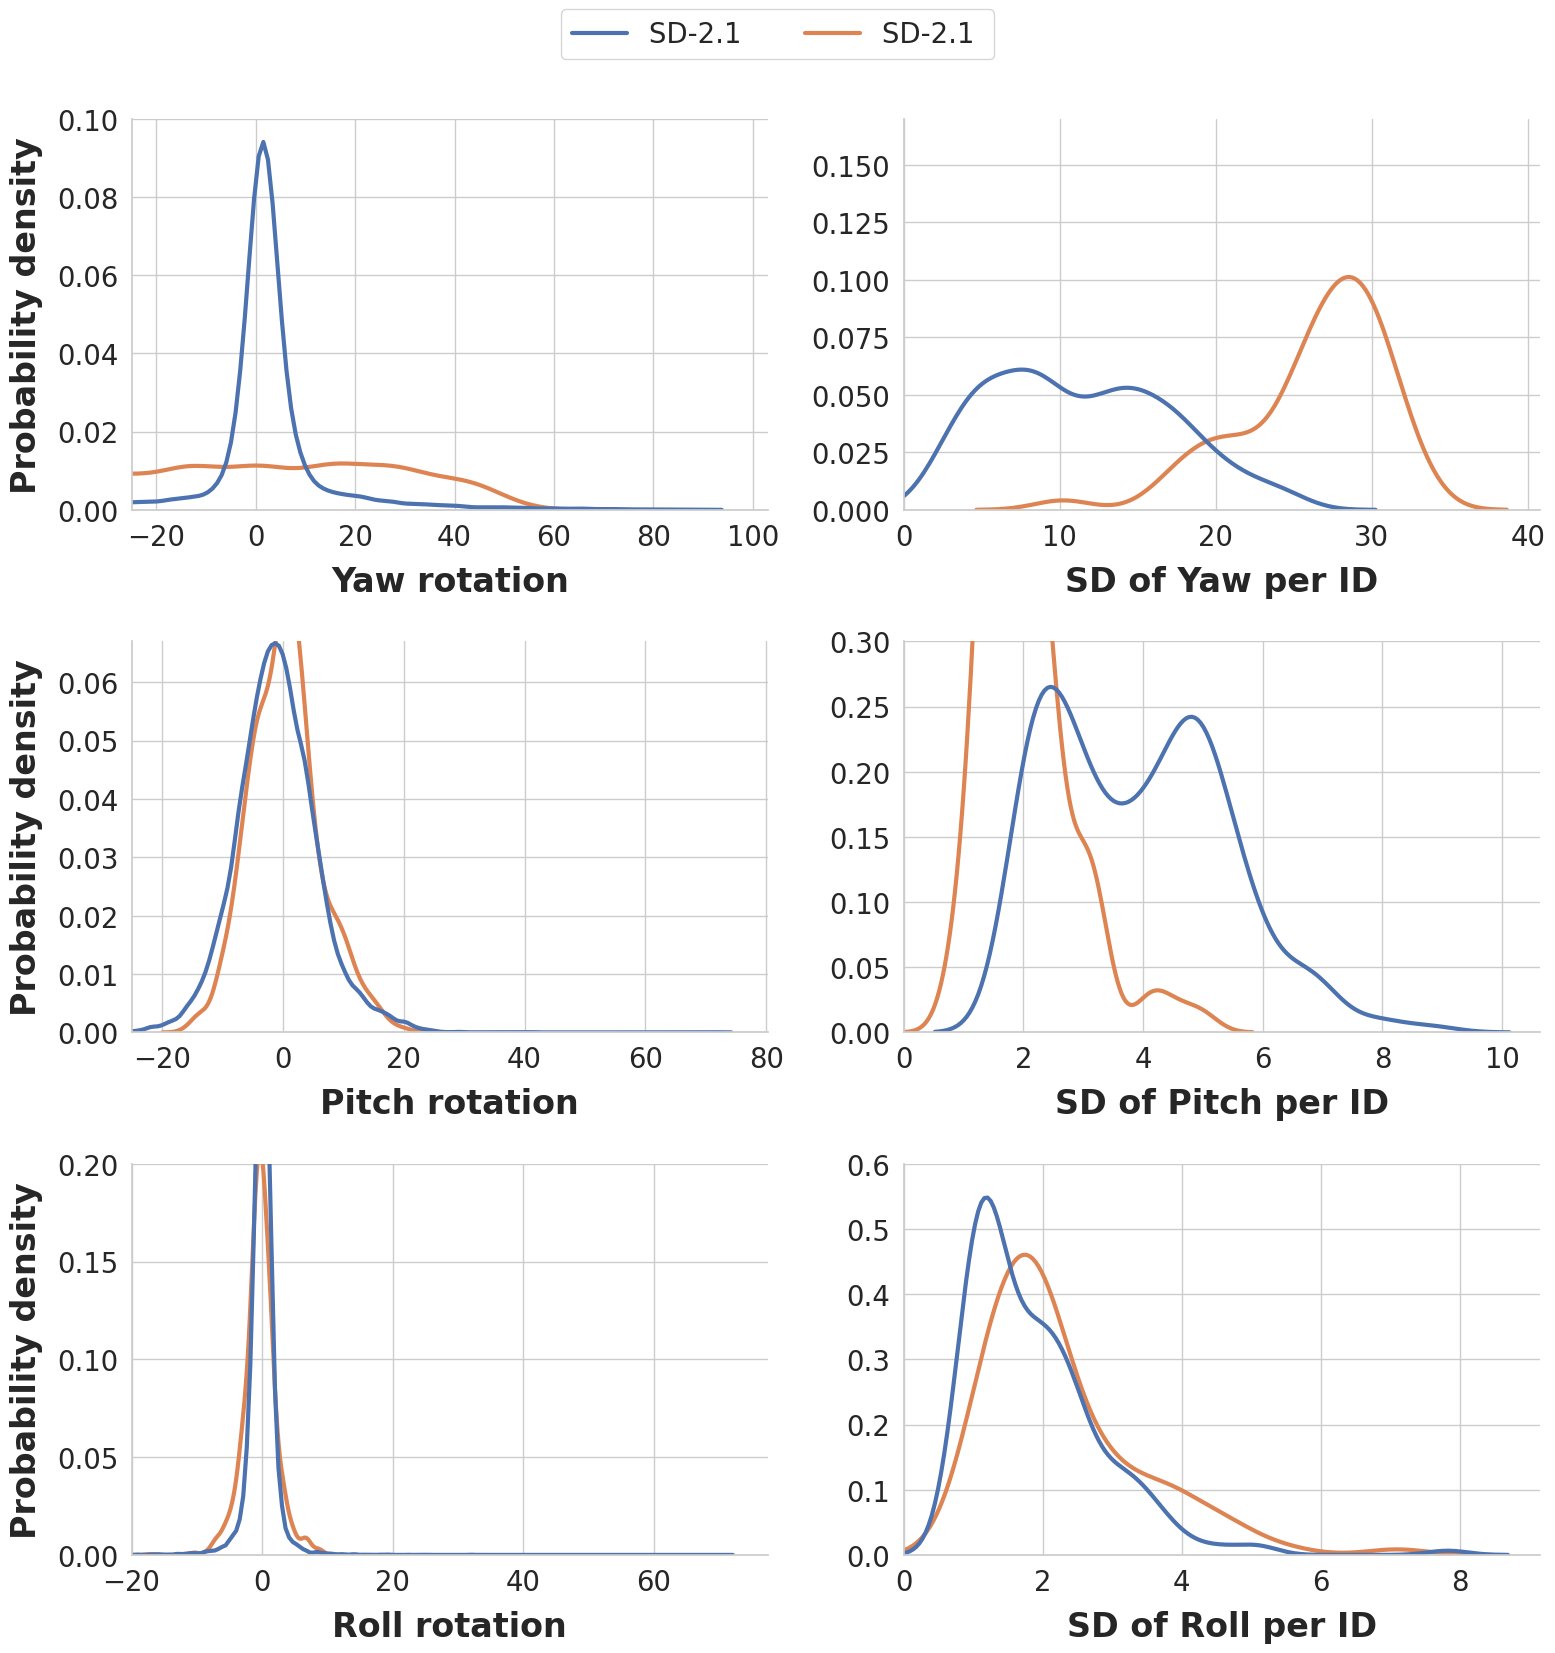

In [10]:

import os
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
def plot_sns_hist(data, ax, name, plot_y, fontsize, y_limit, x_zero_limits):    
    sns.set(font_scale=1.8)
    sns.set_style("whitegrid")

    #ax = sns.kdeplot(data=data, x="Scores", hue="Class",  common_norm=False, linewidth = 2.5)
    ax = sns.kdeplot(data=data,  common_norm=False, linewidth = 3, ax=ax, label=data.columns.tolist())
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.04))
    sns.despine(right=True)
    if plot_y:
        ax.set_xlabel(name, fontsize=fontsize, fontweight="bold", labelpad=10)
        ax.set_ylabel('Probability density', fontsize=fontsize, fontweight="bold", labelpad=10)
    else: 
        ax.set_xlabel(name, fontsize=fontsize, fontweight="bold", labelpad=10)
        ax.set_ylabel('')
    ax.get_legend().remove()

    ax.set_ylim(0.0, y_limit)

    if x_zero_limits != None:
        ax.set_xlim(x_zero_limits, None)
    fig.tight_layout()



files = os.listdir(output_folder)

files = [f for f in  new_order if f != " "]

df_yaw = pd.DataFrame()
df_yaw_per_id = pd.DataFrame()

df_pitch = pd.DataFrame()
df_pitch_per_id = pd.DataFrame()

df_roll = pd.DataFrame()
df_roll_per_id = pd.DataFrame()


fig, axs = plt.subplots(ncols=2,nrows=3,  figsize=(16,16))
fontsize = 24

#which_two_attributes = ["yaw", "yaw_per_id"]
# which_attributes = [["yaw", "yaw_per_id"], ["pitch", "pitch_per_id"], ["roll", "roll_per_id"]]


for file in files: 
    
    if "BACK" in file: continue 
    if file == " ": 
        print("\midrule")
        continue 
    
    #file = os.path.join(main_output_folder, file)
    filepath = os.path.join(main_output_folder, file)
    # print(filepath)
    with open(filepath) as f:
        res_json = json.load(f)

        file = name_translator_dict[file]
        print(f"{file} & ${round(np.mean(res_json['pitch']), 3)} \pm {round(np.std(res_json['pitch']), 3)}$ & \
              ${round(np.mean(res_json['yaw']), 3)} \pm {round(np.std(res_json['yaw']), 3)}$ & \
                ${round(np.mean(res_json['roll']), 3)} \pm {round(np.std(res_json['roll']), 3)}$" , end=" ")
        
        #file = file + f"()"
        print("\\\\")

        ### YAW 
        df_tmp = pd.DataFrame()
        df_tmp[file] = res_json["yaw"]
        df_yaw = pd.concat([df_yaw,df_tmp], axis=1)
        
        list_per_id = []
        dict_per_id = res_json["yaw_per_id"]

        for id in dict_per_id: 
            list_per_id.append(np.std(dict_per_id[id]))

        df_tmp = pd.DataFrame()
        df_tmp[file] = list_per_id
        df_yaw_per_id = pd.concat([df_yaw_per_id,df_tmp], axis=1)
        
        ### PITCH 
        df_tmp = pd.DataFrame()
        df_tmp[file] = res_json["pitch"]
        df_pitch = pd.concat([df_pitch,df_tmp], axis=1)
        
        list_per_id = []
        dict_per_id = res_json["pitch_per_id"]

        for id in dict_per_id: 
            list_per_id.append(np.std(dict_per_id[id]))

        df_tmp = pd.DataFrame()
        df_tmp[file] = list_per_id
        df_pitch_per_id = pd.concat([df_pitch_per_id,df_tmp], axis=1)

        ### ROLL 
        df_tmp = pd.DataFrame()
        df_tmp[file] = res_json["roll"]
        df_roll = pd.concat([df_roll,df_tmp], axis=1)
        
        list_per_id = []
        dict_per_id = res_json["roll_per_id"]

        for id in dict_per_id: 
            list_per_id.append(np.std(dict_per_id[id]))

        df_tmp = pd.DataFrame()
        df_tmp[file] = list_per_id
        df_roll_per_id = pd.concat([df_roll_per_id,df_tmp], axis=1)

        #df_pitch[file] = res_json['pitch']
        #df_roll[file] = res_json['roll']

# for attribute_names in which_attributes:

plot_sns_hist(df_yaw, axs[0][0], "Yaw rotation", plot_y=True, fontsize=fontsize, y_limit=0.1, x_zero_limits=-25)
plot_sns_hist(df_yaw_per_id, axs[0][1], "SD of Yaw per ID", plot_y=False, fontsize=fontsize, y_limit=0.17, x_zero_limits=0.0)

plot_sns_hist(df_pitch, axs[1][0], "Pitch rotation", plot_y=True, fontsize=fontsize, y_limit=0.067, x_zero_limits=-25)
plot_sns_hist(df_pitch_per_id, axs[1][1], "SD of Pitch per ID", plot_y=False, fontsize=fontsize, y_limit=0.30, x_zero_limits=0.0)

plot_sns_hist(df_roll, axs[2][0], "Roll rotation", plot_y=True, fontsize=fontsize, y_limit=0.2, x_zero_limits=-20)
plot_sns_hist(df_roll_per_id, axs[2][1], "SD of Roll per ID", plot_y=False, fontsize=fontsize, y_limit=0.6, x_zero_limits=0.0)



#axs[1].set_yticklabels([])
#axs[2].set_yticklabels([])
handles, labels = axs[0][0].get_legend_handles_labels()
labels_new = list(df_yaw.columns) 
labels_new = [l[:50] for l in labels_new ]
# print(labels)
handles.reverse()
fig.legend(handles, labels_new, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
fig.tight_layout()
# fig.savefig("Paper_Head_Pose_estimation_DB.pdf", bbox_inches='tight') 


# SD-2.1       & $0.564 \pm 7.284$ &               $5.581 \pm 24.825$ &                 $0.084 \pm 3.707$ \\
# SD-2.1 +  ID & $0.905 \pm 8.614$ &               $7.788 \pm 31.145$ &                 $0.291 \pm 5.261$ \\
# SD-2.1 + TID & $0.282 \pm 8.823$ &               $8.073 \pm 31.365$ &                 $0.237 \pm 5.39$ \\
# tufts       & $1.513 \pm 6.691$ &               $4.851 \pm 24.654$ &                 $0.004 \pm 3.127$ \\
# FFHQ       & $-3.779 \pm 8.769$ &               $2.601 \pm 15.339$ &                 $0.395 \pm 3.15$ \\

In [11]:


#files = os.listdir(output_folder)

from shutil import which


to_plot = [f for f in  new_order if f != " "]
for which_attribute in ["pitch", "yaw", "roll"]:
    print(which_attribute)
    for file in new_order:#files: 
        # print(file)
        #print(file, )
        #print("")
        if "BACK" in file: continue 
        if file == " ": 
            print("\midrule")
            continue 
        
        #print(file)
        # filepath = 
        with open(os.path.join(main_output_folder, file)) as f:
            res_json = json.load(f)
            # print(res_json.keys())
            name = name_translator_dict[file]

            all_vals = res_json[which_attribute]
            val_per_id_dict = res_json[f"{which_attribute}_per_id"]
            
            std_per_id_list = []

            for id in val_per_id_dict:
                std_per_id_list.append(np.std(val_per_id_dict[id]))

            print(f"{name} & ${np.mean(all_vals):.3f} \pm {np.std(all_vals):.3f}$ &  ${np.mean(std_per_id_list):.3f} \pm {np.std(std_per_id_list):.3f}$" , end=" ")
            print("\\\\")
    print("===" * 30)
    #break 
    # TUFTS (training)  & 95 & $6.505 \pm 1.643$ & $6.503 \pm 1.640$ \\
    #     \midrule

pitch
SD-2.1  & $-2.215 \pm 6.856$ &  $5.147 \pm 0.962$ \\
SD-2.1  & $0.282 \pm 6.506$ &  $2.738 \pm 0.681$ \\
tufts       & $0.354 \pm 5.830$ &  $2.015 \pm 0.718$ \\
yaw
SD-2.1  & $1.767 \pm 16.471$ &  $15.592 \pm 4.307$ \\
SD-2.1  & $1.959 \pm 8.452$ &  $7.254 \pm 3.470$ \\
tufts       & $0.183 \pm 27.483$ &  $26.296 \pm 4.609$ \\
roll
SD-2.1  & $-0.106 \pm 2.726$ &  $2.522 \pm 0.949$ \\
SD-2.1  & $0.074 \pm 1.465$ &  $1.269 \pm 0.448$ \\
tufts       & $-0.343 \pm 2.644$ &  $2.285 \pm 1.115$ \\


In [12]:



#files = os.listdir(output_folder)

from shutil import which


to_plot = [f for f in  new_order if f != " "]
for file in new_order:#files: 
    print(file)
    for which_attribute in ["pitch", "yaw", "roll"]:
        #print(which_attribute)
    
        # print(file)
        #print(file, )
        #print("")
        if "BACK" in file: continue 
        if file == " ": 
            print("\midrule")
            continue 
        
        #print(file)
        # filepath = 
        with open(os.path.join(main_output_folder, file)) as f:
            res_json = json.load(f)
            # print(res_json.keys())
            name = name_translator_dict[file]

            all_vals = res_json[which_attribute]
            val_per_id_dict = res_json[f"{which_attribute}_per_id"]
            
            std_per_id_list = []

            for id in val_per_id_dict:
                std_per_id_list.append(np.std(val_per_id_dict[id]))
            
            print(f" & ${np.mean(std_per_id_list):.3f} \pm {np.std(std_per_id_list):.3f}$" , end=" ")
            #print("")
            #print(f" & ${np.mean(std_per_id_list):.3f} \pm {np.std(std_per_id_list, ddof=1) / np.sqrt(np.size(std_per_id_list)):.3f}$" , end=" ")
            #print("")
    print("\\\\")
    print("===" * 30)
    #break 
    # TUFTS (training)  & 95 & $6.505 \pm 1.643$ & $6.503 \pm 1.640$ \\
    #     \midrule


01-2025_ID-Booth_ABLATION/+Background_NoNegPrompt.json
 & $5.147 \pm 0.962$  & $15.592 \pm 4.307$  & $2.522 \pm 0.949$ \\
01-2025_ID-Booth_ABLATION/Base_NoNegPrompt.json
 & $2.738 \pm 0.681$  & $7.254 \pm 3.470$  & $1.269 \pm 0.448$ \\
tufts_512_poses_1-7_all_imgs_jpg_per_ID/tufts_images.json
 & $2.015 \pm 0.718$  & $26.296 \pm 4.609$  & $2.285 \pm 1.115$ \\
